# <center>Multiclass Vegetable Classification Using Transfer Learning</center>


<h1><center> Idea behind using Transfer learning </center></h1> 

- <h2>Here, we have used transfer learning. Instread of training a deep neural network form scratch, we have actualy used layers of a pre trained model  and added to our network as they contain important features for classification since they were already trained for a diffrerent task.</h2><br>

- <h2> We will use InceptionV3 which is a network already trained on more than a million images from the ImageNet database </h2>

- <h2> This model will be helpful in object detection with good accuracy. </h2>

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns


import tensorflow as tf
import tensorflow.keras.backend as bk
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt


bk.clear_session()


# <b>Loading the dataset</b>
# <hr>

### Let's define the path to base directories used in the project </h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import zipfile
import os

!unzip drive/MyDrive/Vegetable_image_classification/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [ ]:
dataset='Vegetable Images'

train_images = os.path.join(dataset,"train")
test_images = os.path.join(dataset,"validation")
validation_images = os.path.join(dataset,"test")

<h2>Counting number of images in a folder. (test set in our case)</h2>

In [ ]:
def count_image_files(rootdir):
    '''function to count the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("Found " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name)  + " folder")
 
count_image_files(os.path.join(test_images))

Found 200 files in Cabbage folder
Found 200 files in Potato folder
Found 200 files in Tomato folder
Found 200 files in Carrot folder
Found 200 files in Bitter_Gourd folder
Found 200 files in Cauliflower folder
Found 200 files in Pumpkin folder
Found 200 files in Bean folder
Found 200 files in Bottle_Gourd folder
Found 200 files in Radish folder
Found 200 files in Cucumber folder
Found 200 files in Broccoli folder
Found 200 files in Capsicum folder
Found 200 files in Brinjal folder
Found 200 files in Papaya folder


 Our Dataset is well balanced with each class containing : 
    
- 1000 images for training set. 
    
- 200 images for test set. 

#<b>2. Image Processing</b>
<hr>
Image processing aims to improve graphical information for human comprehension. Basic manipulation and filtering can also lead to better feature extraction knowledge. We can pick any vegetable we like, and a random image from the class will be displayed alongside a processed image.


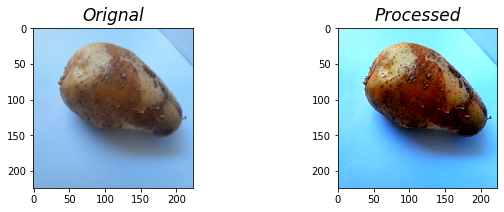

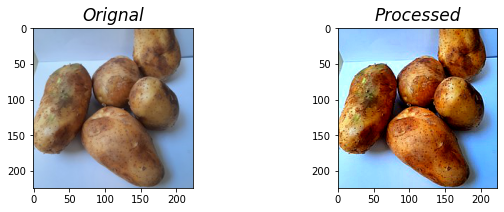

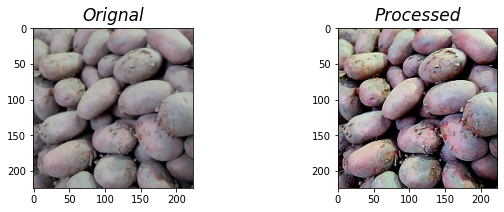

In [ ]:

image_folder="Potato"  # The vegetable you want to display
number_of_images= 3

def preprocess_images():
    count=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_images,image_folder)
        random_choice=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,random_choice))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,count)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        count+=1

        image_enhanced=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image_enhanced=ImageEnhance.Contrast(image_enhanced).enhance(1.45)
        image_enhanced=ImageEnhance.Sharpness(image_enhanced).enhance(2.5)
        
        plt.subplot(number_of_images,2,count)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image_enhanced)
        count+=1
        
preprocess_images()

### We increased the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter


# <b> Data Visualization (EDA)</b>

<hr>

### We can start exploring the dataset and visualize any class label <i>(for instance, Capsicum)</i>. You can choose any vegetable to visualize the images of that class. Changing rows and columns variable also results in different format positioning of matplotlib.

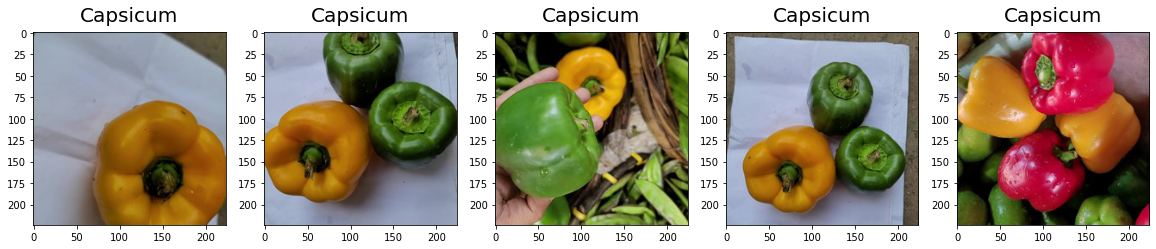

In [ ]:

select_vegetable="Capsicum"
rows,columns = 1,5

display_folder=os.path.join(train_images,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_images,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)   
    if i==total_images-1:
        break

### visualizing the whole dataset by picking a random image from each class inside training dataset. 

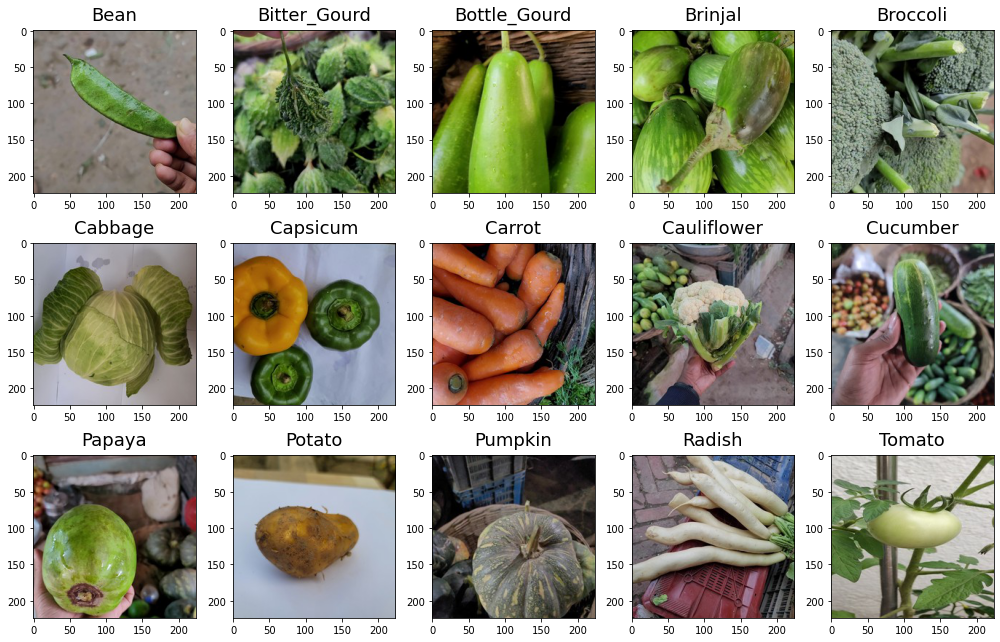

In [ ]:
images = []


for folder in sorted(os.listdir(train_images)):
    fi = os.listdir(train_images + '/' + folder)
    selected = np.random.choice(fi)
    images.append(os.path.join(train_images,folder,selected))
                                     
fig=plt.figure(1, figsize=(14, 9))

for sp,img in enumerate(images):
    cat=img.split('/')[-2]
    imgs = plt.imread(img)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, sp+1)
    fig.set_title(cat, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

### There are 15 vegetables (output classes) and one random image from each class helps in determining basic outlook of dataset and what picture quality along with different metric are visible. 

# <span style="color:blue"><b>4. Model Building</b></span>
<hr>
<h2> Let's start building the transfer learning network to train our model using <u>InceptionV3</u>. </h2>

In [ ]:
IMAGE_SIZE = [224, 224]

inception_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception_model.layers:
    layer.trainable = False

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

final_model = Model(inputs=inception_model.input, outputs=prediction)

final_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D


In [ ]:
img_width=224
img_height=224
img_size=(img_width, img_height)
img_channels=3

In [ ]:
i= Input(shape=IMAGE_SIZE + [3])
x=Conv2D(32,(3,3),input_shape=(IMAGE_SIZE + [3]),padding="same", activation='relu')(i)
x= Dropout(0.2)(x)
x= MaxPooling2D(pool_size=(2,2))(x)

x=Conv2D(64,(3,3), activation='relu', padding='same')(x)
x= Dropout(0.2)(x)

x=Conv2D(64,(3,3), activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2,2))(x)

x=Conv2D(128,(3,3), activation='relu', padding='same')(x)
x= Dropout(0.2)(x)

x=Conv2D(128, (3,3), activation='relu', padding='same')(x)
x= MaxPooling2D(pool_size=(2,2))(x)

x=Flatten()(x)
x= Dropout(0.2)(x)

x=Dense(1024, activation='relu')(x)
x= Dropout(0.2)(x)

x=Dense(512, activation='relu')(x)
x= Dropout(0.2)(x)

x = Dense(15, activation='softmax')(x)

In [ ]:
cnn_model = Model(inputs=i, outputs =x )

cnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 dropout_1 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                           

# <span style="color:blue"><b>5. Model Training</b></span>
<hr>

In [ ]:


train_datagenerator = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagenerator = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagenerator.flow_from_directory(
    train_images,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagenerator.flow_from_directory(
    test_images, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

class_map = training_set.class_indices
class_map

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [EarlyStopping(patience=10), lr_reduction]




Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


Convolutional Model


In [ ]:
epochs=20
r_cnn = cnn_model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=epochs,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks
)

Epoch 1/20
235/235 [==============================] - 193s 763ms/step - loss: 2.0922 - accuracy: 0.2821 - val_loss: 1.6706 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 2/20
 23/235 [=>............................] - ETA: 2:36 - loss: 1.3998 - accuracy: 0.5319

tl model

In [ ]:

r = final_model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks
)




Epoch 1/5
235/235 [==============================] - 177s 732ms/step - loss: 0.2831 - accuracy: 0.9158 - val_loss: 0.0430 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 2/5
235/235 [==============================] - 169s 719ms/step - loss: 0.0708 - accuracy: 0.9778 - val_loss: 0.0320 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/5
235/235 [==============================] - 168s 716ms/step - loss: 0.0507 - accuracy: 0.9849 - val_loss: 0.0233 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 4/5
235/235 [==============================] - 168s 714ms/step - loss: 0.0380 - accuracy: 0.9893 - val_loss: 0.0193 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/5
235/235 [==============================] - 168s 713ms/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0155 - val_accuracy: 0.9940 - lr: 0.0010


## Saving the Model

In [ ]:
final_model.save('model_inceptionV3.h5')
cnn_model.save('model_cnn.h5')

## Accuracy and Loss Curves

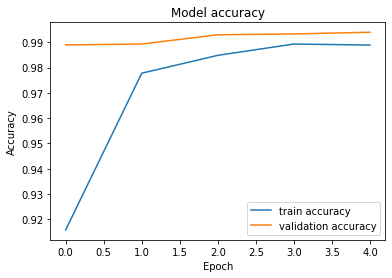

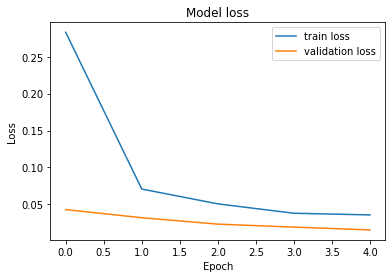

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

cnn model

PlottingAccuracy


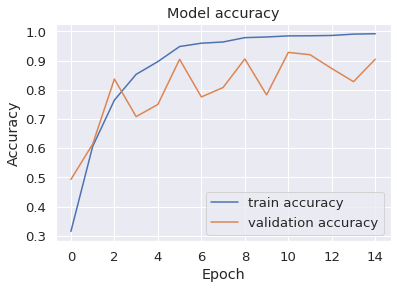

Plotting Loss


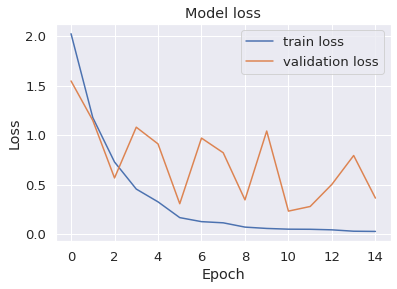

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
print("PlottingAccuracy")
plot_accuracy(r_cnn)
print("Plotting Loss")
plot_loss(r_cnn)

## Model Layers

In [ ]:
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 dropout_1 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                           

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
print("Total layers in the model : ",len(final_model.layers),"\n")

layers = [layer.output for layer in final_model.layers[0:]]
layer_names = []
for layer in final_model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])


Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


# <b><span style="color:blue">6. Predictions</span></b>
<hr>
<h2> Loading the model </h2>

In [ ]:
bk.clear_session()
path_to_model='model_inceptionV3.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [ ]:
bk.clear_session()
path_to_model='model_cnn.h5'
print("Loading the model..")
cnn_model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


## Testing the model on validation set

In [ ]:
validation_data_dir = 'Vegetable Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.994


cnn model

In [ ]:
val_datagen = image.ImageDataGenerator(rescale=1. / 255)

val_gen = val_datagen.flow_from_directory(
    'Vegetable Images/test',
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

val_scores_cnn = cnn_model.evaluate_generator(val_gen)
print("Test Accuracy: {:.3f}".format(val_scores_cnn[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.899


<h2> Functions to predict the output of our model

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

- <h3> Single image prediction </h3>

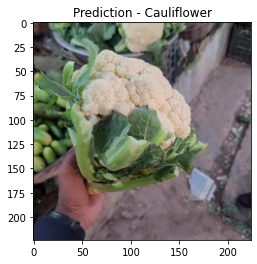

In [ ]:
predict_image(os.path.join(validation_images,'Cauliflower/1064.jpg'),model)

- <h3> Validation directory accuracy prediction </h3>

In [ ]:
for i in os.listdir(validation_images):
    predict_dir(os.path.join(validation_images,i),model)

Accuracy for Cabbage: 0.99 (199/200)
Accuracy for Potato: 0.99 (199/200)
Accuracy for Tomato: 0.98 (197/200)
Accuracy for Carrot: 1.00 (200/200)
Accuracy for Bitter_Gourd: 0.99 (198/200)
Accuracy for Cauliflower: 0.99 (199/200)
Accuracy for Pumpkin: 0.99 (199/200)
Accuracy for Bean: 0.99 (198/200)
Accuracy for Bottle_Gourd: 0.99 (199/200)
Accuracy for Radish: 1.00 (200/200)
Accuracy for Cucumber: 0.99 (198/200)
Accuracy for Broccoli: 0.99 (199/200)
Accuracy for Capsicum: 1.00 (200/200)
Accuracy for Brinjal: 1.00 (200/200)
Accuracy for Papaya: 0.99 (198/200)


# <b><span style="color:blue">7. Evaluation</span></b>
<hr> 
<h2> Loading the model </h2>

## Confusion Matrix for evaluating the performance of our classification model.

In [ ]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="Blues"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_images)


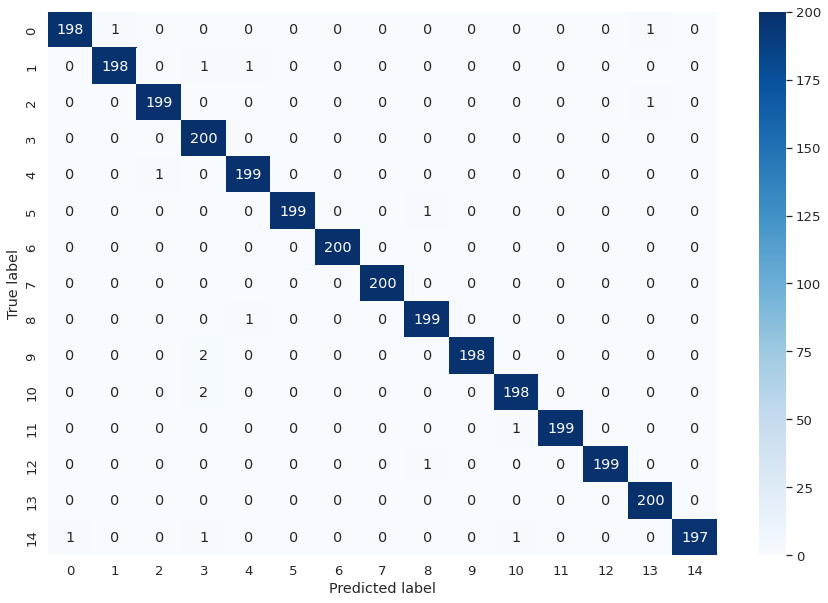

In [ ]:
print_confusion_matrix(y_true,y_pred)

## Visualizing all incorrect images predicted for a particular vegetable category by our classifier. 

In [ ]:
def wrong_input_capture(test_category):
    
    a=os.path.basename(test_category)
    wrong_array=[]
    
    for i in os.listdir(test_category):
        
        imggg=os.path.join(test_category,i)
        
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        
        index = np.argmax(prediction)
        pred=category.get(index)
        
        if not pred==a:
            wrong_array.append((imggg,pred))
            
    return wrong_array
    
def visualize_wrong_input(images):
    
    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)
        
    plt.tight_layout()

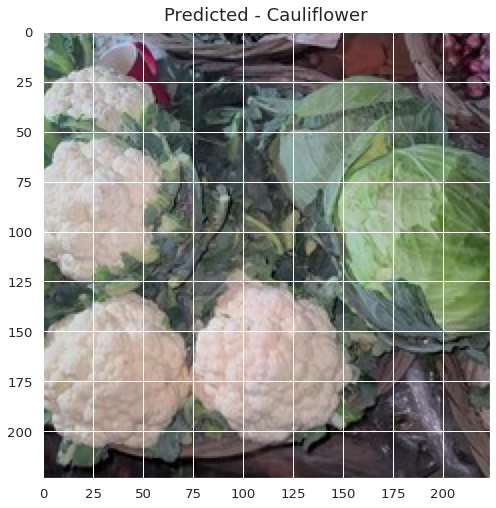

In [ ]:
vegetable="Cabbage"
path=os.path.join(validation_images,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)

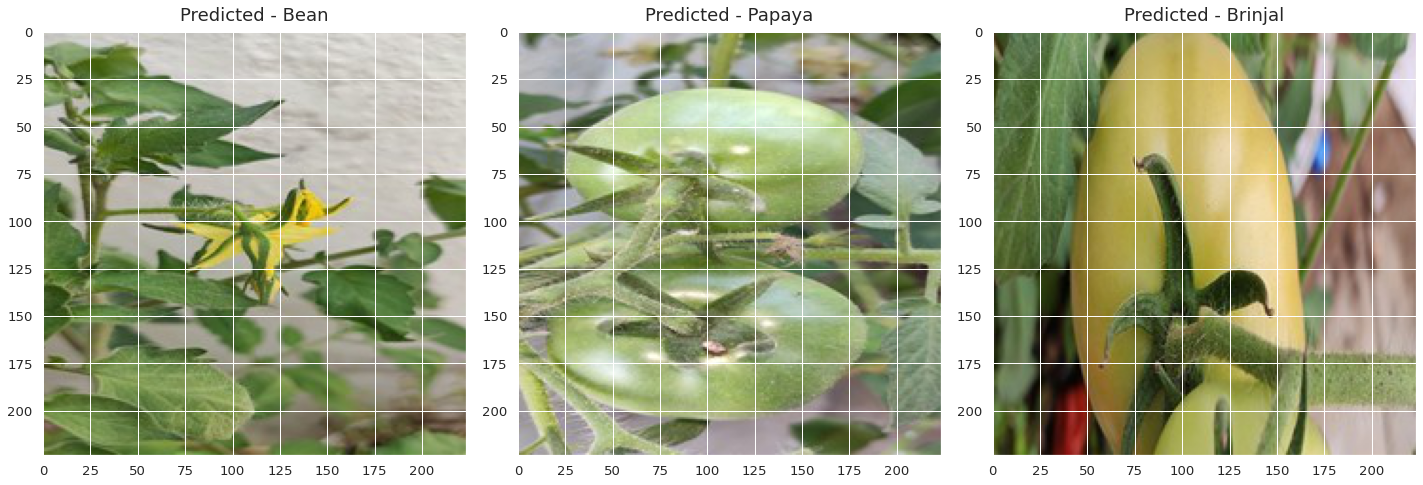

In [ ]:
vegetable="Tomato"
path=os.path.join(validation_images,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)

##As we can see, the false positives are really low as we have used transfer learning which has given us good accuracy!